In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.metrics import r2_score
import math
import warnings
import csv
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import autograd
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
file_path = "/content/NGAsub_MegaFlatfile_RotD50_050_R211022_public.xlsx"
df = pd.read_excel(file_path)

In [ ]:
df.rename(columns={
    'PGA_g': 'pga',
    'Earthquake_Magnitude': 'mag',
    'Rjb_km': 'rjb',
    'Hypocenter_Depth_km': 'hypd',
    'Vs30_Selected_for_Analysis_m_s': 'vs30',
    'Intra_Inter_Flag': 'intra_inter',
    'Sensor_Depth_m': 'sensor_depth',
    'Multiple_Event': 'multi_event',
    'Late_P_trigger_flag_1ptYes_0ptNo': 'late_flag',
    'Source_review_flag': 'src_flag',
    'Longest_Usable_Period_for_PSa_Ave_Component_sec': 'tgm',
    'NGAsubEQID': 'EqID',
    'Station_Name':'siteID'
}, inplace=True)

In [ ]:
df = df[(df['pga'] != -999) & (df['pga'] <= 10) & (df['mag'] >= 4)]

meta_cols = ['mag', 'rjb', 'hypd', 'vs30',"Ztor_km"]
for col in meta_cols:
    df = df[df[col] != -999]

df = df[df['intra_inter'].isin([0, 1, 5])]

is_interface = (df['intra_inter'] == 0) & (df['hypd'] < 40)
is_intraslab = (df['intra_inter'] == 1) & (df['hypd'] < 200)
df = df[is_interface | is_intraslab]

df = df[df['rjb'] <= 1000]

df = df[df['sensor_depth'] <= 2]

df = df[df['multi_event'] != 1]

df = df[df['late_flag'] != 1]

df = df[df['src_flag'].isin([0, 1, 2, 4])]

df = df[df['tgm'] >= 10]

event_counts = df['EqID'].value_counts()
valid_eids = event_counts[event_counts >= 3].index
df = df[df['EqID'].isin(valid_eids)]
df.shape

(14526, 227)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']
target_cols = [
    "T0pt010S", "T0pt020S", "T0pt030S", "T0pt050S", "T0pt075S",
    "T0pt100S", "T0pt150S", "T0pt200S", "T0pt300S", "T0pt400S",
    "T0pt500S", "T0pt750S", "T1pt000S", "T1pt500S", "T2pt000S",
    "T2pt500S", "T3pt000S", "T3pt500S", "T4pt000S", "T5pt000S"
]

# Assume df is already loaded
df['logrjb'] = np.log10(df['rjb'])
df['logvs30'] = np.log10(df['vs30'])

X_real = df[input_cols].copy()
for col in target_cols:
    X_real[col] = np.log10(df[col])

X_real.replace([np.inf, -np.inf], np.nan, inplace=True)
X_real.dropna(inplace=True)

X_train, X_temp = train_test_split(X_real, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Scale only input features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train[input_cols])

X_train_scaled = X_train.copy()
X_train_scaled[input_cols] = scaler.transform(X_train[input_cols])

X_val_scaled = X_val.copy()
X_val_scaled[input_cols] = scaler.transform(X_val[input_cols])

X_test_scaled = X_test.copy()
X_test_scaled[input_cols] = scaler.transform(X_test[input_cols])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(25, 16),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x, c):
        c = c.view(c.size(0), -1)
        x = torch.cat((x, c), dim=1)
        return self.model(x.float())

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(16, 32),
            nn.ReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(32, 20)
        )
    def forward(self, z, c):
        c = c.view(c.size(0), -1)
        x = torch.cat((z, c), dim=1)
        return self.model(x.float())

In [ ]:
def generate_real_samples(df_real, n):
    sample = df_real.sample(n)
    cond = torch.tensor(sample[input_cols].values, dtype=torch.float32).to(device)
    target = torch.tensor(sample[target_cols].values, dtype=torch.float32).to(device)
    return target, cond

def generate_latent_points(latent_dim, n_samples):
    return torch.randn((n_samples, latent_dim), device=device)

def generate_fake_samples(generator, latent_dim, n_samples, conditions):
    z = generate_latent_points(latent_dim, n_samples)
    conditions = torch.tensor(conditions, dtype=torch.float32).to(device)
    return generator(z, conditions), conditions

def predict(conditions_test, generator):
    generator.eval()
    with torch.no_grad():
        z = torch.randn((conditions_test.shape[0], 5), device=device)  # Create latent points based on conditions_test size
        c = torch.tensor(conditions_test, dtype=torch.float32).to(device)
        preds = generator(z, c)

        # Instead of concatenating with X_test_scaled, use conditions_test
        input_values = torch.tensor(conditions_test, dtype=torch.float32).to(device)
        preds = torch.cat((input_values, preds), dim=1).cpu().numpy()
        return preds

In [ ]:
def train(g_model, d_model, data, val_data, latent_dim=5, n_epochs=4000, n_batch=128, best_r2=-1e6):
    batch_per_epoch = max(1, len(data) // n_batch)
    half_batch = n_batch // 2

    y_real = torch.ones((half_batch, 1), device=device)
    y_fake = torch.zeros((half_batch, 1), device=device)

    for epoch in range(n_epochs):
        for _ in range(batch_per_epoch):
            real_X, real_c = generate_real_samples(data, half_batch)
            fake_X, fake_c = generate_fake_samples(g_model, latent_dim, half_batch, real_c.cpu().numpy())

            d_model.zero_grad()
            loss_real = criterion(d_model(real_X, real_c), y_real)
            loss_fake = criterion(d_model(fake_X.detach(), fake_c), y_fake)
            d_loss = loss_real + loss_fake
            d_loss.backward()
            dis_optimizer.step()

            g_model.zero_grad()
            g_loss = criterion(d_model(fake_X, fake_c), y_real)
            g_loss.backward()
            gen_optimizer.step()

        if epoch % 100 == 0:
            conditions_val = val_data[input_cols].to_numpy()
            preds = predict(conditions_val, g_model)
            true_vals = val_data[input_cols + target_cols].to_numpy()
            preds = preds  # Already scaled + log-transformed

            curr_r2 = r2_score(true_vals[:, len(input_cols):], preds[:, len(input_cols):])
            print(f"Epoch {epoch}: R2 = {curr_r2:.4f}, Best R2 = {best_r2:.4f}")

            if curr_r2 > best_r2:
                torch.save(g_model.state_dict(), 'best_generator.pth')
                torch.save(d_model.state_dict(), 'best_discriminator.pth')
                best_r2 = curr_r2

            with open('results.csv', 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([epoch, best_r2, curr_r2, d_loss.item(), g_loss.item()])

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()

gen_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))

train(generator, discriminator, X_train_scaled, X_val_scaled)

Epoch 0: R2 = -6.2174, Best R2 = -1000000.0000
Epoch 100: R2 = 0.6876, Best R2 = -6.2174
Epoch 200: R2 = 0.6398, Best R2 = 0.6876
Epoch 300: R2 = 0.6880, Best R2 = 0.6876
Epoch 400: R2 = 0.6992, Best R2 = 0.6880
Epoch 500: R2 = 0.6600, Best R2 = 0.6992
Epoch 600: R2 = 0.6228, Best R2 = 0.6992
Epoch 700: R2 = 0.6341, Best R2 = 0.6992
Epoch 800: R2 = 0.5879, Best R2 = 0.6992
Epoch 900: R2 = 0.6495, Best R2 = 0.6992
Epoch 1000: R2 = 0.6561, Best R2 = 0.6992
Epoch 1100: R2 = 0.7039, Best R2 = 0.6992
Epoch 1200: R2 = 0.5931, Best R2 = 0.7039
Epoch 1300: R2 = 0.5904, Best R2 = 0.7039
Epoch 1400: R2 = 0.5690, Best R2 = 0.7039
Epoch 1500: R2 = 0.5662, Best R2 = 0.7039
Epoch 1600: R2 = 0.5726, Best R2 = 0.7039
Epoch 1700: R2 = 0.6423, Best R2 = 0.7039
Epoch 1800: R2 = 0.6493, Best R2 = 0.7039
Epoch 1900: R2 = 0.6578, Best R2 = 0.7039
Epoch 2000: R2 = 0.6110, Best R2 = 0.7039
Epoch 2100: R2 = 0.6262, Best R2 = 0.7039
Epoch 2200: R2 = 0.6652, Best R2 = 0.7039
Epoch 2300: R2 = 0.6501, Best R2 = 0.

In [ ]:
generator.load_state_dict(torch.load('best_generator.pth'))
discriminator.load_state_dict(torch.load('best_discriminator.pth'))

conditions_test = X_test_scaled[input_cols].to_numpy()
true_values = X_test_scaled[input_cols + target_cols].to_numpy()

outputs = []
for _ in range(1000):
    out = predict(conditions_test, generator)
    outputs.append(out)

mean_output = np.mean(outputs, axis=0)

r_squared_test = r2_score(true_values[:, len(input_cols):], mean_output[:, len(input_cols):])
print("Final R² on test set (PSa only):", r_squared_test)

Final R² on test set (PSa only): 0.8026401370161503


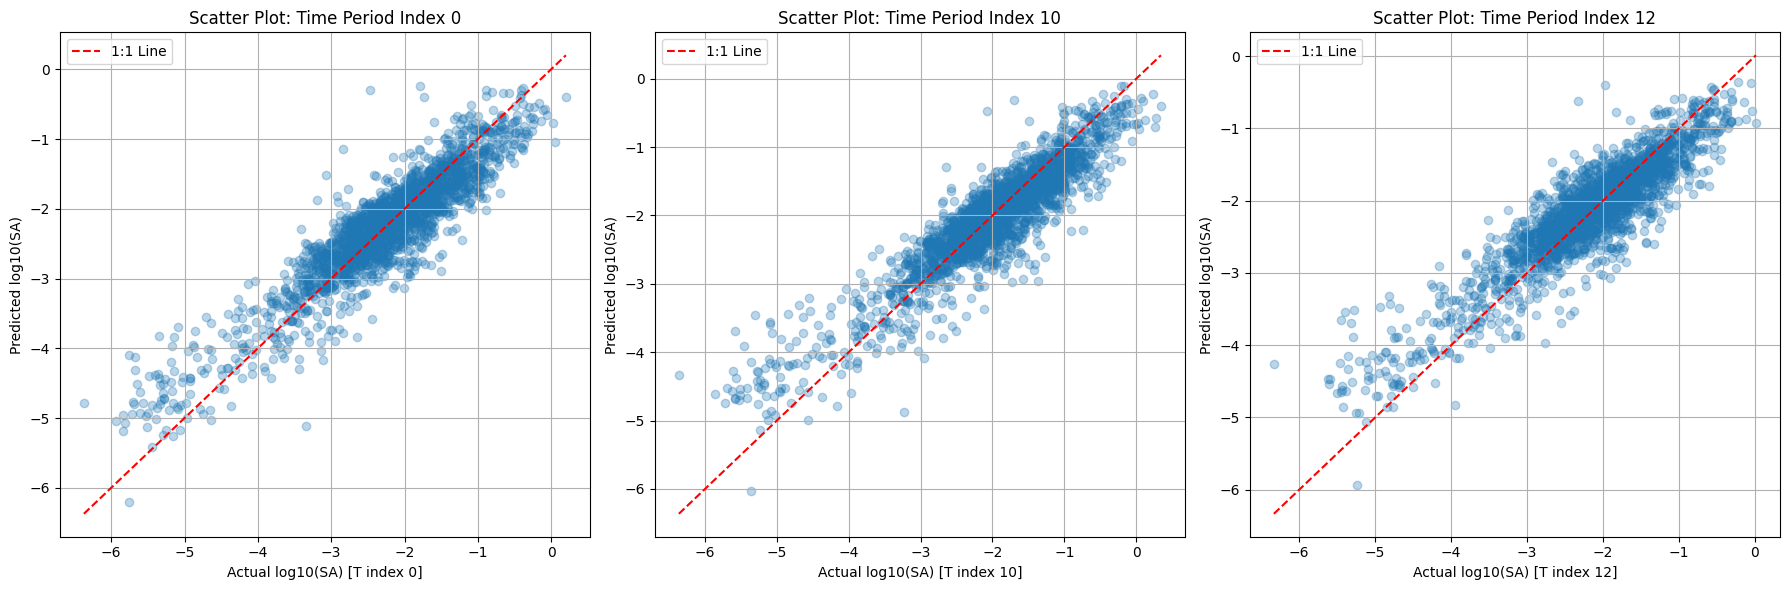

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spectral_indices = [0, 10, 12]

Y_test_log = true_values[:, len(input_cols):]
Y_pred_log = mean_output[:, len(input_cols):]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, idx in enumerate(spectral_indices):
    ax = axs[i]
    ax.scatter(Y_test_log[:, idx], Y_pred_log[:, idx], alpha=0.3)
    ax.plot([Y_test_log[:, idx].min(), Y_test_log[:, idx].max()],
            [Y_test_log[:, idx].min(), Y_test_log[:, idx].max()], 'r--', label='1:1 Line')

    ax.set_xlabel(f'Actual log10(SA) [T index {idx}]')
    ax.set_ylabel('Predicted log10(SA)')
    ax.set_title(f'Scatter Plot: Time Period Index {idx}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

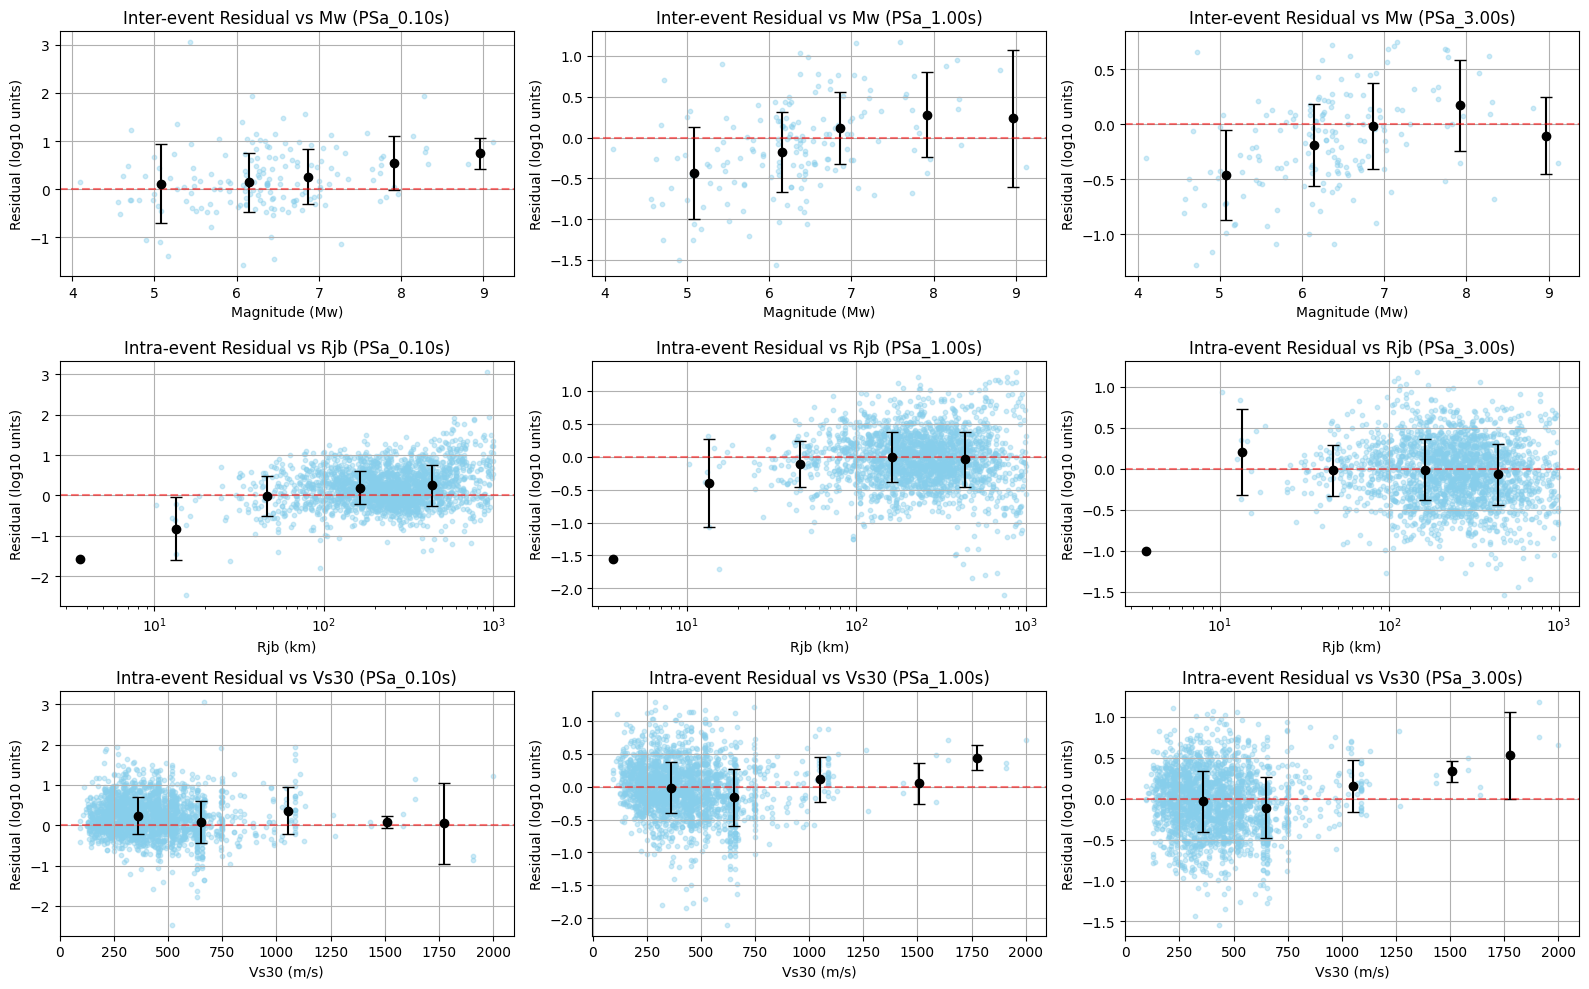

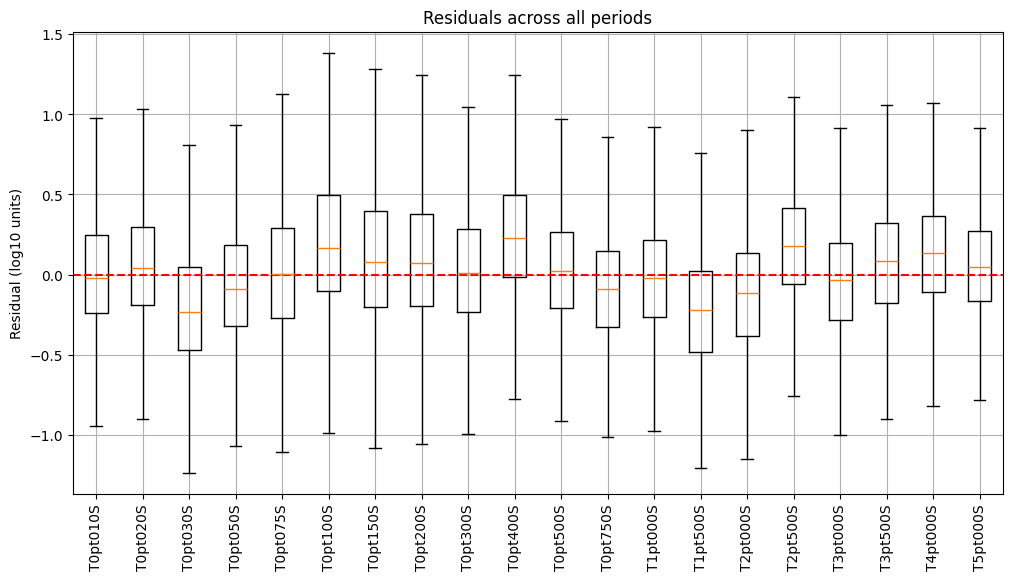

In [ ]:
def get_cgan_predictions(generator, conditions, n_samples=1000):
    """Generate predictions by sampling multiple times and averaging"""
    all_preds = []
    for _ in range(n_samples):
        pred = predict(conditions, generator)
        all_preds.append(pred)
    return np.mean(all_preds, axis=0)

# Get mean predictions
conditions_test = X_test_scaled[input_cols].to_numpy()
y_pred_scaled = get_cgan_predictions(generator, conditions_test)

y_pred_log = y_pred_scaled[:, len(input_cols):]  # Extract just the target predictions
y_test_log = X_test_scaled[target_cols].to_numpy()

# 3. Compute residuals
residuals_log = y_test_log - y_pred_log
eq_ids = df.loc[X_test_scaled.index, 'EqID'].values
eq_unique, eq_idx_original = np.unique(eq_ids, return_index=True)
eq_idx = [idx for idx in eq_idx_original if idx < residuals_log.shape[0]]

inter_event = residuals_log[eq_idx]
intra_event = residuals_log

# 5. Time periods and labels
time_periods = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4,
                0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]
selected_indices = [5, 12, 16]  # Indices for 0.1s, 1.0s, 3.0s periods
selected_labels = [f"PSa_{time_periods[i]:.2f}s" for i in selected_indices]

# Plotting function (same as yours)
def plot_residual_binned(x, y, xlabel, title, log_x=False, bins=6, ax=None):
    df_plot = pd.DataFrame({'x': x, 'y': y})
    df_plot['bin'] = pd.cut(df_plot['x'], bins=bins)

    bin_centers = df_plot.groupby('bin')['x'].mean()
    bin_means = df_plot.groupby('bin')['y'].mean()
    bin_stds = df_plot.groupby('bin')['y'].std()

    if ax is None:
        ax = plt.gca()
    ax.scatter(x, y, alpha=0.4, s=10, color='skyblue')
    ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black', capsize=4)
    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Residual (log10 units)")
    ax.set_title(title)
    if log_x:
        ax.set_xscale("log")
    ax.grid(True)

# 6. Plotting
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

# Get the original (unscaled) values for plotting
X_test_unscaled = X_test.loc[X_test_scaled.index]

for col, i in enumerate(selected_indices):
    # Magnitude (Mw) for inter-event residuals
    if len(inter_event) > 0:  # Only plot if we have inter-event residuals
        Mw_vals = X_test_unscaled['mag'].values[eq_idx_original]
        Mw_vals_filtered = Mw_vals[np.array(eq_idx_original) < residuals_log.shape[0]]

        plot_residual_binned(
            Mw_vals_filtered,
            inter_event[:, i],
            xlabel="Magnitude (Mw)",
            title=f"Inter-event Residual vs Mw ({selected_labels[col]})",
            bins=np.linspace(4.5, 9.5, 6),
            ax=axs[0, col]
        )
    else:
        axs[0, col].axis('off')  # Turn off if no inter-event residuals

    # Rjb for intra-event
    plot_residual_binned(
        X_test_unscaled['rjb'].values[:intra_event.shape[0]],
        intra_event[:, i],
        xlabel="Rjb (km)",
        title=f"Intra-event Residual vs Rjb ({selected_labels[col]})",
        bins=np.logspace(0, 3, 6),
        log_x=True,
        ax=axs[1, col]
    )

    # Vs30 for intra-event
    plot_residual_binned(
    np.power(10,X_test_unscaled['logvs30'].values[:intra_event.shape[0]]), # Using 10**logvs30 and slicing to intra_event.shape[0]
    intra_event[:, i],
    xlabel="Vs30 (m/s)",
    title=f"Intra-event Residual vs Vs30 ({selected_labels[col]})",
    bins=np.linspace(180, 2000, 6),
    ax=axs[2, col]
)


plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
plt.boxplot(residuals_log, positions=range(len(target_cols)), showfliers=False)
plt.xticks(range(len(target_cols)), target_cols, rotation=90)
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Residual (log10 units)')
plt.title('Residuals across all periods')
plt.grid(True)
plt.show()

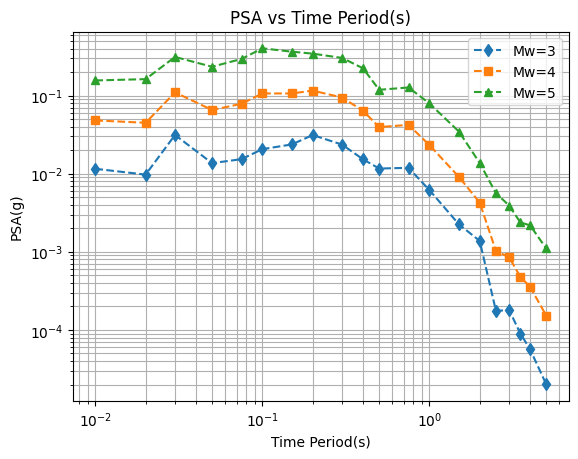

In [ ]:
PSA_tp = np.array([0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5])

X_plot = pd.DataFrame(columns=['mag', 'rjb', 'logvs30', 'intra_inter'])  # Conditional inputs
# Changed: Using rjb instead of logrjb
X_plot.loc[0] = [3, 10, math.log10(760), 0]
X_plot.loc[1] = [4, 10, math.log10(760), 0]
X_plot.loc[2] = [5, 10, math.log10(760), 0]

#Calculate logrjb after creating the DataFrame
X_plot['logrjb'] = np.log10(X_plot['rjb'])


# Scale the inputs using the scaler
X_plot_scaled = scaler.transform(X_plot[['mag','rjb','logrjb', 'logvs30', 'intra_inter']]) # Selecting the correct columns for scaling

# Prepare a list to collect outputs
mean_output = []

# Generate predictions multiple times to get a mean output
for i in range(1000):
    output = predict(X_plot_scaled, generator) # Assuming your predict function is defined and takes scaled data
    # Inverse scale the predictions (assuming you have a scaler for outputs as well)
    #output = scaler.inverse_transform(output)
    mean_output.append(output)

# Calculate the mean and convert from log scale
mean_array = np.mean(mean_output, axis=0)

# Assuming output shape is (3, 25) for 3 magnitudes and 25 periods
# If you have a different output, adjust the slicing and plotting accordingly
plt.plot(PSA_tp, np.power(10, mean_array[0, 5:]), linestyle='--', marker='d', label="Mw=3")
plt.plot(PSA_tp, np.power(10, mean_array[1, 5:]), linestyle='--', marker='s', label="Mw=4")
plt.plot(PSA_tp, np.power(10, mean_array[2, 5:]), linestyle='--', marker='^', label="Mw=5")


# Customize the plot
plt.grid(True, which="both")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")
plt.title("PSA vs Time Period(s)")
plt.xlabel("Time Period(s)")
plt.ylabel("PSA(g)")
# Show the plot
plt.show()

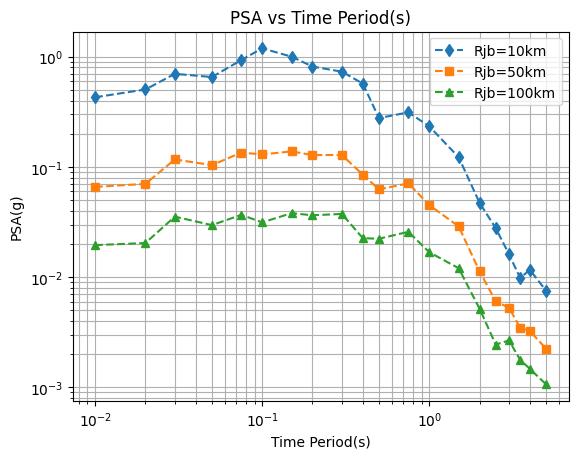

In [ ]:
PSA_tp = np.array([0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5])

X_plot = pd.DataFrame(columns=['mag', 'rjb','logrjb', 'logvs30', 'intra_inter'])  # Conditional inputs
# Changed: Using rjb instead of logrjb
X_plot.loc[0] = [6.5, 10,math.log10(10), math.log10(760), 0]
X_plot.loc[1] = [6.5, 50,math.log10(50),math.log10(760), 0]
X_plot.loc[2] = [6.5, 100,math.log10(100), math.log10(760), 0]

#Calculate logrjb after creating the DataFrame
X_plot['logrjb'] = np.log10(X_plot['rjb'])


# Scale the inputs using the scaler
X_plot_scaled = scaler.transform(X_plot[['mag','rjb','logrjb', 'logvs30', 'intra_inter']]) # Selecting the correct columns for scaling

# Prepare a list to collect outputs
mean_output = []

# Generate predictions multiple times to get a mean output
for i in range(1000):
    output = predict(X_plot_scaled, generator) # Assuming your predict function is defined and takes scaled data
    # Inverse scale the predictions (assuming you have a scaler for outputs as well)
    #output = scaler.inverse_transform(output)
    mean_output.append(output)

# Calculate the mean and convert from log scale
mean_array = np.mean(mean_output, axis=0)

plt.plot(PSA_tp, np.power(10, mean_array[0, 5:]), linestyle='--', marker='d', label="Rjb=10km")
plt.plot(PSA_tp, np.power(10, mean_array[1, 5:]), linestyle='--', marker='s', label="Rjb=50km")
plt.plot(PSA_tp, np.power(10, mean_array[2, 5:]), linestyle='--', marker='^', label="Rjb=100km")


# Customize the plot
plt.grid(True, which="both")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")
plt.title("PSA vs Time Period(s)")
plt.xlabel("Time Period(s)")
plt.ylabel("PSA(g)")
# Show the plot
plt.show()

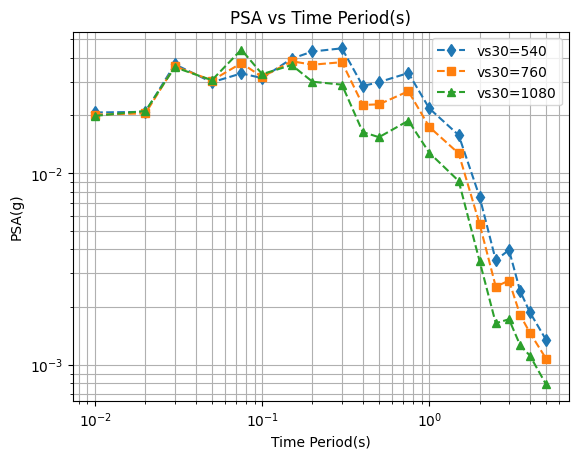

In [ ]:
PSA_tp = np.array([0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 5])

X_plot = pd.DataFrame(columns=['mag', 'rjb','logrjb', 'logvs30', 'intra_inter'])  # Conditional inputs
# Changed: Using rjb instead of logrjb
X_plot.loc[0] = [6.5, 100,math.log10(100), math.log10(540), 0]
X_plot.loc[1] = [6.5, 100,math.log10(100),math.log10(760), 0]
X_plot.loc[2] = [6.5, 100,math.log10(100), math.log10(1080), 0]

#Calculate logrjb after creating the DataFrame
X_plot['logrjb'] = np.log10(X_plot['rjb'])


# Scale the inputs using the scaler
X_plot_scaled = scaler.transform(X_plot[['mag','rjb','logrjb', 'logvs30', 'intra_inter']]) # Selecting the correct columns for scaling

# Prepare a list to collect outputs
mean_output = []

# Generate predictions multiple times to get a mean output
for i in range(1000):
    output = predict(X_plot_scaled, generator) # Assuming your predict function is defined and takes scaled data
    # Inverse scale the predictions (assuming you have a scaler for outputs as well)
    #output = scaler.inverse_transform(output)
    mean_output.append(output)

# Calculate the mean and convert from log scale
mean_array = np.mean(mean_output, axis=0)

plt.plot(PSA_tp, np.power(10, mean_array[0, 5:]), linestyle='--', marker='d', label="vs30=540")
plt.plot(PSA_tp, np.power(10, mean_array[1, 5:]), linestyle='--', marker='s', label="vs30=760")
plt.plot(PSA_tp, np.power(10, mean_array[2, 5:]), linestyle='--', marker='^', label="vs30=1080")


# Customize the plot
plt.grid(True, which="both")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")
plt.title("PSA vs Time Period(s)")
plt.xlabel("Time Period(s)")
plt.ylabel("PSA(g)")
# Show the plot
plt.show()

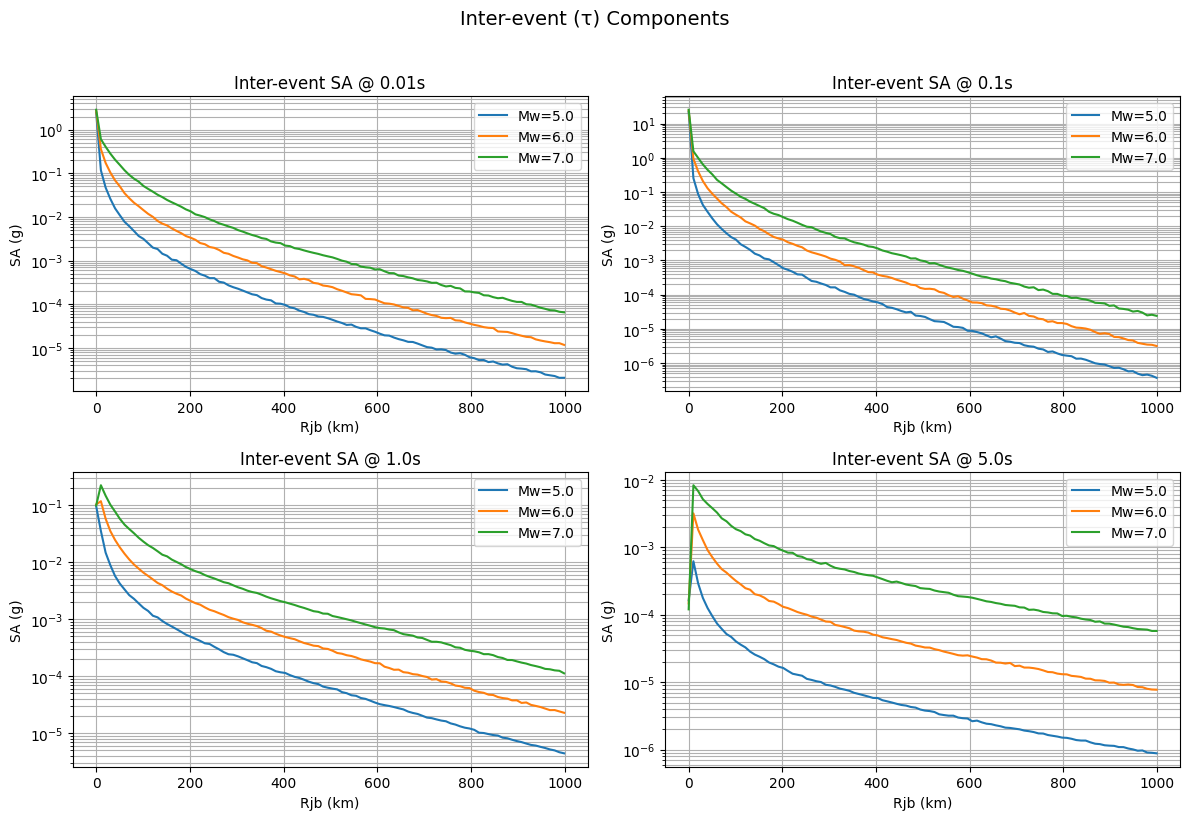

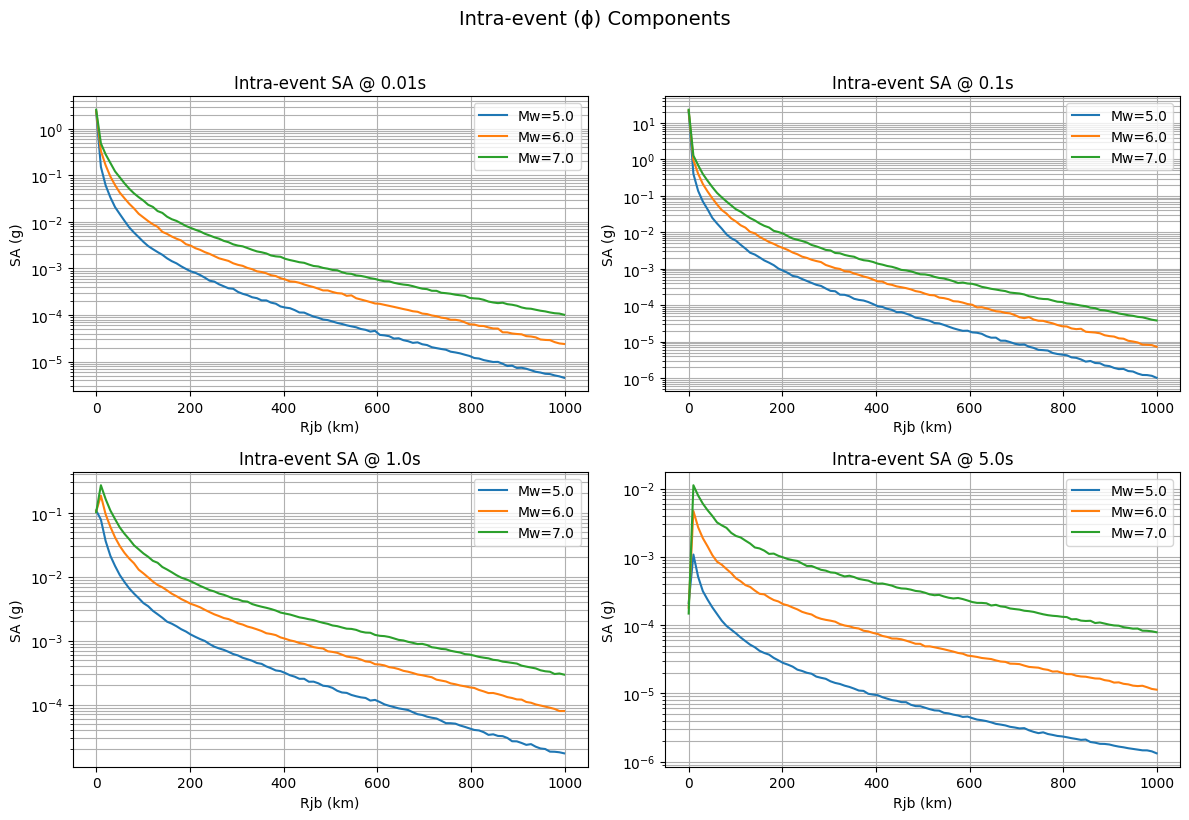

In [ ]:
selected_period_indices = [0, 5, 12, 19]  # Example: 0.01s, 0.1s, 1.0s, 5.0s
selected_periods = [float(target_cols[i][1:].replace('pt', '.').replace('S', ''))
                   for i in selected_period_indices]

# Distance range (km)
rjb_range = np.linspace(df['rjb'].min() + 1e-6, df['rjb'].max(), 100)

# Magnitude values to plot
mw_values = [5.0, 6.0, 7.0]

# Fixed Vs30 value (m/s)
fixed_vs30 = 760
logvs30 = np.log10(fixed_vs30)

# Function to generate predictions for given conditions
def generate_predictions(generator, conditions, n_samples=1000):
    """Generate predictions by sampling multiple times and averaging"""
    all_preds = []
    for _ in range(n_samples):
        pred = predict(conditions, generator)
        all_preds.append(pred)
    return np.mean(all_preds, axis=0)

# Plot inter-event components (intra_inter = 1)
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            # Create input array (order must match input_cols)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 1]])  # 1 for inter-event

            # Scale input features
            X_scaled = scaler.transform(X_input)

            # Generate predictions (returns both inputs and targets)
            y_pred_scaled = generate_predictions(generator, X_scaled)

            # Extract just the target predictions (log10 values)
            y_pred_log = y_pred_scaled[:, len(input_cols):]

            # Convert to linear space (g units)
            y_pred = np.power(10, y_pred_log)
            sa_values.append(y_pred[0, iT])

        plt.semilogy(rjb_range, sa_values, label=f'Mw={mw}')

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Inter-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Inter-event (τ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Plot intra-event components (intra_inter = 0)
plt.figure(figsize=(12, 8))
for idx, iT in enumerate(selected_period_indices):
    plt.subplot(2, 2, idx + 1)

    for mw in mw_values:
        sa_values = []
        for rjb in rjb_range:
            logrjb = np.log10(rjb)
            # Create input array (order must match input_cols)
            X_input = np.array([[mw, rjb, logrjb, logvs30, 0]])  # 0 for intra-event

            # Scale input features
            X_scaled = scaler.transform(X_input)

            # Generate predictions (returns both inputs and targets)
            y_pred_scaled = generate_predictions(generator, X_scaled)

            # Extract just the target predictions (log10 values)
            y_pred_log = y_pred_scaled[:, len(input_cols):]

            # Convert to linear space (g units)
            y_pred = np.power(10, y_pred_log)
            sa_values.append(y_pred[0, iT])

        plt.semilogy(rjb_range, sa_values, label=f'Mw={mw}')

    plt.xlabel("Rjb (km)")
    plt.ylabel("SA (g)")
    plt.title(f"Intra-event SA @ {selected_periods[idx]}s")
    plt.grid(True, which="both", ls="-")
    plt.legend()

plt.suptitle("Intra-event (ϕ) Components", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

y_pred_all = get_cgan_predictions(generator, conditions_test)  # Get predictions for all periods
y_true = X_test_scaled[target_cols].to_numpy() # Assumes this is your true target data
residuals = y_true - y_pred_all[:, len(input_cols):] # Calculate residuals for all periods

f_mech = X_test_scaled['intra_inter'].to_numpy()

# Loop through each period and compute statistics
for period_idx in range(residuals.shape[1]):
    # 1. Flatten residuals for the current period
    residual_flat = residuals[:, period_idx]

    # 2. Create DataFrame for analysis
    data = pd.DataFrame({
        'residual': residual_flat,
        'f_mech': f_mech
    })

    # 3. Inter-event residuals (mean residual per event)
    inter_event = data.groupby('f_mech')['residual'].mean().rename('inter_event')

    # 4. Merge with original DataFrame
    data = data.join(inter_event, on='f_mech')

    # 5. Intra-event residual = residual - inter_event
    data['intra_event'] = data['residual'] - data['inter_event']

    # 6. Variance breakdown
    sigma_total = np.std(data['residual'], ddof=1)
    tau = np.std(data['inter_event'].unique(), ddof=1)
    phi = np.std(data['intra_event'], ddof=1)

    print(f"Period Index: {period_idx}")
    print(f"Total Std Dev (σ): {sigma_total:.3f}")
    print(f"Inter-event Std Dev (τ): {tau:.3f}")
    print(f"Intra-event Std Dev (ϕ): {phi:.3f}")
    print("-" * 20) # Separator between periods

Period Index: 0
Total Std Dev (σ): 0.396
Inter-event Std Dev (τ): 0.045
Intra-event Std Dev (ϕ): 0.395
--------------------
Period Index: 1
Total Std Dev (σ): 0.398
Inter-event Std Dev (τ): 0.083
Intra-event Std Dev (ϕ): 0.394
--------------------
Period Index: 2
Total Std Dev (σ): 0.423
Inter-event Std Dev (τ): 0.031
Intra-event Std Dev (ϕ): 0.422
--------------------
Period Index: 3
Total Std Dev (σ): 0.412
Inter-event Std Dev (τ): 0.027
Intra-event Std Dev (ϕ): 0.412
--------------------
Period Index: 4
Total Std Dev (σ): 0.442
Inter-event Std Dev (τ): 0.029
Intra-event Std Dev (ϕ): 0.442
--------------------
Period Index: 5
Total Std Dev (σ): 0.471
Inter-event Std Dev (τ): 0.073
Intra-event Std Dev (ϕ): 0.468
--------------------
Period Index: 6
Total Std Dev (σ): 0.456
Inter-event Std Dev (τ): 0.036
Intra-event Std Dev (ϕ): 0.456
--------------------
Period Index: 7
Total Std Dev (σ): 0.457
Inter-event Std Dev (τ): 0.093
Intra-event Std Dev (ϕ): 0.452
--------------------
Period I